## Preparing

In [ ]:
# Since Google Colab removed the ability to connect to Google Drive from 
# a non-current account, there is some hack that still allows you to do this.
#
# You need to follow the link that will appear in the output and login to the 
# account that owns the desired Google Drive.
#
# After that, you need to run the next cell.
#
# https://stackoverflow.com/questions/69819761/i-cant-mount-my-another-drive-in-google-colab/70797774#70797774

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive
%cd /content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch

from tqdm.notebook import tqdm

In [ ]:
!mkdir pytorch_fid
!curl https://raw.githubusercontent.com/mseitzer/pytorch-fid/master/src/pytorch_fid/fid_score.py > pytorch_fid/fid_score.py
!curl https://raw.githubusercontent.com/mseitzer/pytorch-fid/master/src/pytorch_fid/inception.py > pytorch_fid/inception.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10647  100 10647    0     0   106k      0 --:--:-- --:--:-- --:--:--  105k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12193  100 12193    0     0   154k      0 --:--:-- --:--:-- --:--:--  154k


In [ ]:
!unzip "/content/drive/MyDrive/Projects/DenoisingDiffusion/dataset/CelebA.zip" > /dev/null

In [ ]:
!git init .
# !git remote add -f origin "https://github.com/Sankek/ImageInpainting"
!git remote add -f origin "https://github.com/Sankek/DenoisingDiffusion"
!git pull origin master

from utils import generate_images, tensor2image
from data import VarianceSchedule

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 43 (delta 14), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (43/43), done.
From https://github.com/Sankek/DenoisingDiffusion
 * [new branch]      master     -> origin/master
From https://github.com/Sankek/DenoisingDiffusion
 * branch            master     -> FETCH_HEAD


In [ ]:
!pip install denoising_diffusion_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 50.3 MB/s 


## FID

In [ ]:
evaluation_folder = '/content/drive/MyDrive/Projects/DenoisingDiffusion/evaluation'
stats_path = '/content/drive/MyDrive/Projects/DenoisingDiffusion/evaluation/CelebA_128x128_statistics.npz'
dataset_path = 'CelebA'
save_folder = '/content/drive/MyDrive/Projects/DenoisingDiffusion/saved'
batch_size = 100
dims = 2048
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 2

### Compute dataset statistics

In [ ]:
from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import compute_statistics_of_path

def compute_statistics(images_path, save_path, batch_size, dims, device, num_workers=1):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)
    m, s = compute_statistics_of_path(
        images_path, model, batch_size, dims, device, num_workers=num_workers
    )
    np.savez(save_path, mu=m, sigma=s)

compute_statistics(dataset_path, stats_path, batch_size, dims, device, num_workers)

### Generate images

In [ ]:
from utils import generate_images, tensor2image
from data import VarianceSchedule

dataset_mean = [0.5]*3 
dataset_std = [0.5]*3
variance_schedule = VarianceSchedule(Tmax=1000)

In [ ]:
model_name = 'ddp_CelebA_3725001'
model_path = os.path.join(save_folder, model_name, 'state.pth')
state = torch.load(model_path, map_location=device)
model = state['model']
model.load_state_dict(state['model_state'])

<All keys matched successfully>

In [ ]:
generated_images_path = f'/content/drive/MyDrive/Projects/DenoisingDiffusion/evaluation/{model_name}'
!mkdir {generated_images_path}

In [ ]:
gen_ims = generate_images(
    model, variance_schedule, num=100, image_size=128, channels=3, device=device, reproducible=True, reproducible_seed=0
)
torch.cuda.empty_cache()

In [ ]:
for i, im in enumerate(tqdm(gen_ims)):
    img = tensor2image(im, dataset_mean, dataset_std)
    Image.fromarray((img*255).astype(np.uint8)).save(os.path.join(generated_images_path, f'{i}.jpg'))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# model_name = ['ddp_CelebA', 'ddp_CelebA_gradaccum5', 'ddp_CelebA_gradaccum25']
# model_name = ['ddp_CelebA_gradaccum25']
# model_name = ['ddp_CelebA', 'ddp_CelebA_gradaccum5']
model_name = ['ddp_CelebA']
states = list(filter(lambda x: x.rsplit('_', maxsplit=1)[0] in model_name, os.listdir(save_folder)))
iters = list(map(lambda x: int(x.rsplit('_', maxsplit=1)[1]), states))

argsort = np.argsort(iters)
states = [states[i] for i in argsort]
iters = [iters[i] for i in argsort]

In [ ]:
states[-1]

'ddp_CelebA_3725001'

### Compute FID

In [ ]:
from pytorch_fid.fid_score import calculate_fid_given_paths

title_dict = {}
for name in os.listdir(evaluation_folder):
    path = os.path.join(evaluation_folder, name)
    if os.path.isdir(path):
        iters = int(name.rsplit('_', maxsplit=1)[1])

        fid_value = calculate_fid_given_paths(
            [stats_path, path], batch_size, device, dims, num_workers
        )
        
        title_dict[name] = dict(iters=iters, fid=fid_value)

print(title_dict)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


{'ddp_CelebA_3300003': {'iters': 3300003, 'fid': 102.9262134219664}, 'ddp_CelebA_2150022': {'iters': 2150022, 'fid': 106.21885658475108}, 'ddp_CelebA_gradaccum25_5392812': {'iters': 5392812, 'fid': 86.0131471095907}, 'ddp_CelebA_gradaccum5_4375023': {'iters': 4375023, 'fid': 84.86194268680413}, 'ddp_CelebA_3725001': {'iters': 3725001, 'fid': 85.00820645043132}}


## Plot images

In [ ]:
title_dict

{'ddp_CelebA_2150022': {'fid': 106.21885658475108, 'iters': 2150022},
 'ddp_CelebA_3300003': {'fid': 102.9262134219664, 'iters': 3300003},
 'ddp_CelebA_3725001': {'fid': 85.00820645043132, 'iters': 3725001},
 'ddp_CelebA_gradaccum25_5392812': {'fid': 86.0131471095907, 'iters': 5392812},
 'ddp_CelebA_gradaccum5_4375023': {'fid': 84.86194268680413, 'iters': 4375023}}

In [ ]:
max_iters = max(map(lambda x: x['iters'], title_dict.values()))

In [ ]:
for state_name, state_values in title_dict.items():
    fid = round(state_values['fid'], 2)
    iters = state_values['iters']
    percent = int(state_values['iters']/max_iters*100)

    title = f"{iters}/{max_iters} ({percent}%), FID = {fid}"

    dir_path = os.path.join(evaluation_folder, state_name)
    imgs_names = sorted(os.listdir(dir_path))

    imgs = []
    for im in imgs_names:
        imgs.append(Image.open(os.path.join(dir_path, im)))

    fig, axs = plt.subplots(5, 20, figsize=(20, 5), squeeze=False)
    for i, ax in enumerate(axs.ravel()):
        ax.imshow(imgs[i])
        ax.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.95, top=0.90, bottom=0.05)
    plt.suptitle(title, fontsize=20)
    plt.savefig(f'graph_{iters}.jpg', dpi=300)

    from google.colab import files
    files.download(f'graph_{iters}.jpg') 

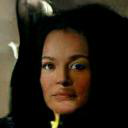

In [ ]:
imgs[0]

In [ ]:
from google.colab import files
files.download(os.path.join(dir_path, imgs_names[0])) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Losses

In [ ]:
# model = ['baseline', 'baseline_finetune', 'baseline_finetune_lr_1e-4', 'baseline_finetune_lr_5e-5']
# model_name = ['baseline_norm_losses', 'baseline_norm_losses_off_bn']
# model_name = ['v2', 'v2_finetune', 'v2_finetune_lr_1e-5']
# model_name = ['ddp']
model_name = ['ddp_CelebA', 'ddp_CelebA_gradaccum5', 'ddp_CelebA_gradaccum25']
# save_folder = '/content/drive/MyDrive/Projects/ImageInpainting/saved'
losses_dict = {}
for save_dir in tqdm(list(filter(lambda x: x.rsplit('_', maxsplit=1)[0] in model_name, os.listdir(save_folder)))):
    name, iters = save_dir.rsplit('_', maxsplit=1)
    path = os.path.join(save_folder, save_dir, 'state.pth')
    if name in model_name:
        state = torch.load(path, map_location='cpu')
        losses = state['losses']
        
        losses_dict[int(iters)] = losses

  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
iters_list = sorted(list(losses_dict.keys()))
full_losses = []
for i in range(1, len(iters_list)):
    cur = len(losses_dict[iters_list[i]])
    prev = len(losses_dict[iters_list[i-1]])
    if cur < prev:
        full_losses += losses_dict[iters_list[i-1]]
        
full_losses += losses_dict[iters_list[-1]]

In [ ]:
def smooth1d(data, window_width):
    """Сглаживает данные усреднением по окну размера window_width"""
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

In [ ]:
losses_names = ['valid_l1', 'hole_l1', 'perceptual_pred', 'perceptual_comp', 'style_pred', 'style_comp', 'tv']
losses = np.array(full_losses).T


In [ ]:
sum_losses = losses.sum(axis=0)

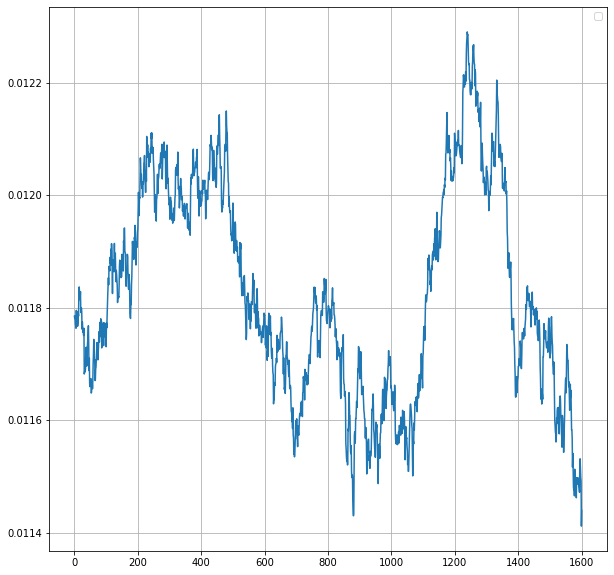

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_yscale('log')
# for loss, name in zip(losses, losses_names):
#     ax.plot(smooth1d(loss, 2000), label=name)
    # ax.plot(loss, label=name)
ax.plot(smooth1d(full_losses[-2000:], 400))
# ax.plot(smooth1d(sum_losses, 2000), label='sum')
# ax.set_xlim(80000, 120000)
# ax.set_ylim(0, 2.5)
# ax.set_ylim(0.43, 0.46)

ax.legend()
ax.grid()
plt.show()

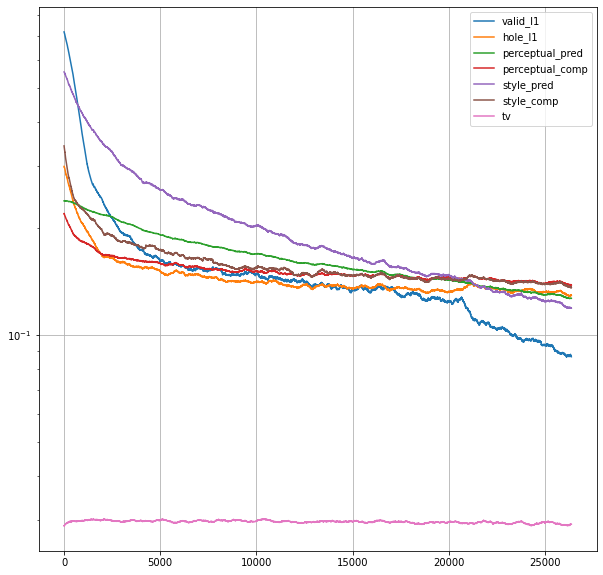

In [ ]:
# norm_losses
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_yscale('log')
for loss, name in zip(losses, losses_names):
    ax.plot(smooth1d(loss, 500), label=name)
    # ax.plot(loss, label=name)
ax.legend()
ax.grid()
plt.show()